In [1]:
import os
import glob
import keras
import librosa.display

import numpy as np
import pandas as pd
import IPython.display as ipd

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, np_utils
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Data Analysis

## Listening

In [2]:
directory = "data2/audio/"

In [3]:
# Bed
word = "bed/"
filename = "00176480_nohash_0"

file_bed = os.path.normcase(directory+word+filename+".wav")
ipd.Audio(file_bed)

In [4]:
# Cat
word = "cat/"
filename = "00f0204f_nohash_0"

file_cat = os.path.normcase(directory+word+filename+".wav")
ipd.Audio(file_cat)

In [5]:
# Happy
word = "happy/"
filename = "0ac15fe9_nohash_0"

file_happy = os.path.normcase(directory+word+filename+".wav")
ipd.Audio(file_happy)

## Waveplot

In [6]:
% pylab inline


def waveplot(file, word):
    data, sampling_rate = librosa.load(file)
    print("Word:"+word)
    print("Sampling rate:", sampling_rate)
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr=sampling_rate)

Populating the interactive namespace from numpy and matplotlib


Word:bed
Sampling rate: 22050


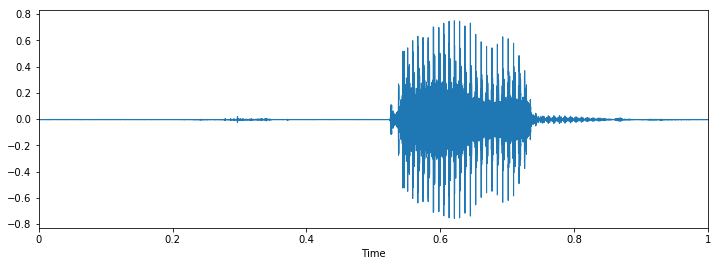

In [7]:
# Bed
word = "bed"
waveplot(file_bed, word)

Word:cat
Sampling rate: 22050


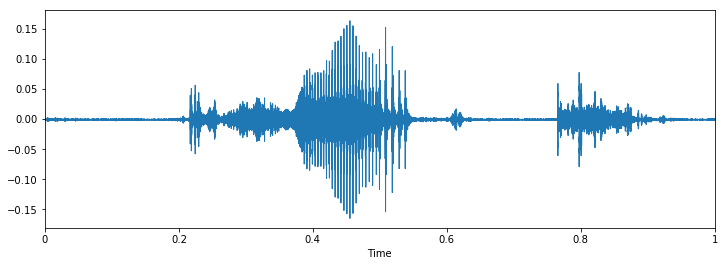

In [8]:
# Cat
word = "cat"
waveplot(file_cat, word)

Word:happy
Sampling rate: 22050


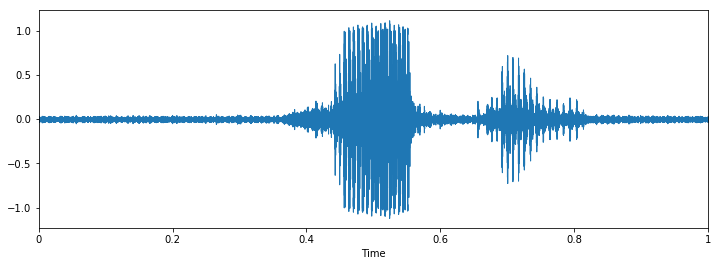

In [9]:
# Happy
word = "happy"
waveplot(file_happy, word)

# Preprocessing Audio Files

## Creating a DataFrame

In [10]:
words = os.listdir(directory)
temps = []
for word in words:
    for wavfile in os.listdir(directory + '/' + word):
        idWAV = wavfile.replace(".wav", "")
        temps.append({"ID": idWAV, "Word": word})
df = pd.DataFrame(temps, columns=["ID", "Word"])

In [11]:
def wav2mfcc(row):
    file = os.path.normcase(directory+row.Word+"/"+row.ID + '.wav')

    try:
        x, sample_rate = librosa.load(file, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(
            y=x, sr=sample_rate, n_mfcc=40).T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None
    return [mfccs, row.Word]

In [12]:
df_temp = df.apply(wav2mfcc, axis=1)

In [13]:
df_temp.columns = ['feature', 'label']

In [14]:
# Number of words
len(df_temp.label.value_counts())

30

In [15]:
# Number min of samples of a word
min(df_temp.label.value_counts())

1713

# Convert the data

In [16]:
x = np.array(df_temp.feature.tolist())
y = np.array(df_temp.label.tolist())

In [17]:
lb = LabelEncoder()
y = np_utils.to_categorical(lb.fit_transform(y))

# feature_dim_1 = 20
# feature_dim_2 = 11
# channel = 1

# Reshaping to perform 2D convolution
#x = x.reshape(x.shape[0], feature_dim_1, feature_dim_2, channel)

In [18]:
np.save("x_deep.npy", x)
np.save("y_deep.npy", y)

# Build Model

## Break Dataset into Training and Testing Sets

In [19]:
test_size = 0.30
random_state = 42

x = np.load("x_deep.npy")
y = np.load("y_deep.npy")

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

# print number of training and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

45304 train samples
19417 test samples


## Model Architecture

In [21]:
num_classes = y.shape[1]
input_shape = x.shape[1]

In [22]:
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                7710      
__________

## Compile the Model

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Train the Model

In [24]:
batch_size = 32
epochs = 200
verbose = 1
validation_split = 0.3

# train the model
checkpointer = ModelCheckpoint(filepath='audio_model_deepLearning.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=[checkpointer],
    validation_split=validation_split)

Train on 31712 samples, validate on 13592 samples
Epoch 1/200
31712/31712 [==============================] - 4s - loss: 15.2562 - acc: 0.0349 - val_loss: 14.9779 - val_acc: 0.0358
Epoch 2/200
31712/31712 [==============================] - 4s - loss: 15.1317 - acc: 0.0383 - val_loss: 13.8380 - val_acc: 0.0479
Epoch 3/200
31712/31712 [==============================] - 4s - loss: 14.8093 - acc: 0.0406 - val_loss: 9.4193 - val_acc: 0.0658
Epoch 4/200
31712/31712 [==============================] - 4s - loss: 6.6749 - acc: 0.0395 - val_loss: 3.3968 - val_acc: 0.0371
Epoch 5/200
31712/31712 [==============================] - 4s - loss: 3.4561 - acc: 0.0385 - val_loss: 3.3933 - val_acc: 0.0373
Epoch 6/200
31712/31712 [==============================] - 4s - loss: 3.4172 - acc: 0.0400 - val_loss: 3.3851 - val_acc: 0.0414
Epoch 7/200
31712/31712 [==============================] - 4s - loss: 3.3976 - acc: 0.0481 - val_loss: 3.3670 - val_acc: 0.0461
Epoch 8/200
31712/31712 [========================

31712/31712 [==============================] - 4s - loss: 2.7108 - acc: 0.2156 - val_loss: 2.5628 - val_acc: 0.2568
Epoch 27/200
31712/31712 [==============================] - 4s - loss: 2.7011 - acc: 0.2147 - val_loss: 2.5775 - val_acc: 0.2575
Epoch 28/200
31712/31712 [==============================] - 4s - loss: 2.6946 - acc: 0.2216 - val_loss: 2.5617 - val_acc: 0.2590
Epoch 29/200
31712/31712 [==============================] - 4s - loss: 2.6883 - acc: 0.2221 - val_loss: 2.5572 - val_acc: 0.2561
Epoch 30/200
31712/31712 [==============================] - 4s - loss: 2.6861 - acc: 0.2240 - val_loss: 2.5505 - val_acc: 0.2596
Epoch 31/200
31712/31712 [==============================] - 4s - loss: 2.6756 - acc: 0.2262 - val_loss: 2.5584 - val_acc: 0.2569
Epoch 32/200
31712/31712 [==============================] - 4s - loss: 2.6762 - acc: 0.2288 - val_loss: 2.5478 - val_acc: 0.2636
Epoch 33/200
31712/31712 [==============================] - 4s - loss: 2.6773 - acc: 0.2250 - val_loss: 2.5387

31712/31712 [==============================] - 4s - loss: 2.6455 - acc: 0.2391 - val_loss: 2.4926 - val_acc: 0.2813
Epoch 55/200
31712/31712 [==============================] - 4s - loss: 2.6351 - acc: 0.2439 - val_loss: 2.5134 - val_acc: 0.2773
Epoch 56/200
31712/31712 [==============================] - 4s - loss: 2.6284 - acc: 0.2419 - val_loss: 2.4978 - val_acc: 0.2763
Epoch 57/200
31712/31712 [==============================] - 4s - loss: 2.6345 - acc: 0.2423 - val_loss: 2.5039 - val_acc: 0.2751
Epoch 58/200
31712/31712 [==============================] - 4s - loss: 2.6366 - acc: 0.2416 - val_loss: 2.5064 - val_acc: 0.2744
Epoch 59/200
31712/31712 [==============================] - 4s - loss: 2.6304 - acc: 0.2449 - val_loss: 2.4922 - val_acc: 0.2822
Epoch 60/200
31712/31712 [==============================] - 4s - loss: 2.6237 - acc: 0.2410 - val_loss: 2.4922 - val_acc: 0.2826
Epoch 61/200
31712/31712 [==============================] - 4s - loss: 2.6360 - acc: 0.2412 - val_loss: 2.4944

31712/31712 [==============================] - 4s - loss: 2.6413 - acc: 0.2402 - val_loss: 2.5175 - val_acc: 0.2762
Epoch 86/200
31712/31712 [==============================] - 4s - loss: 2.6424 - acc: 0.2405 - val_loss: 2.5217 - val_acc: 0.2744
Epoch 87/200
31712/31712 [==============================] - 4s - loss: 2.6445 - acc: 0.2379 - val_loss: 2.5242 - val_acc: 0.2724
Epoch 88/200
31712/31712 [==============================] - 4s - loss: 2.6439 - acc: 0.2415 - val_loss: 2.5227 - val_acc: 0.2794
Epoch 89/200
31712/31712 [==============================] - 4s - loss: 2.6490 - acc: 0.2385 - val_loss: 2.5110 - val_acc: 0.2847
Epoch 90/200
31712/31712 [==============================] - 4s - loss: 2.6414 - acc: 0.2410 - val_loss: 2.5190 - val_acc: 0.2810
Epoch 91/200
31712/31712 [==============================] - 4s - loss: 2.6459 - acc: 0.2413 - val_loss: 2.5039 - val_acc: 0.2816
Epoch 92/200
31712/31712 [==============================] - 4s - loss: 2.6412 - acc: 0.2406 - val_loss: 2.5112

31712/31712 [==============================] - 4s - loss: 2.6514 - acc: 0.2416 - val_loss: 2.5478 - val_acc: 0.2718
Epoch 118/200
31712/31712 [==============================] - 4s - loss: 2.6659 - acc: 0.2380 - val_loss: 2.5399 - val_acc: 0.2769
Epoch 119/200
31712/31712 [==============================] - 4s - loss: 2.6592 - acc: 0.2371 - val_loss: 2.5559 - val_acc: 0.2722
Epoch 120/200
31712/31712 [==============================] - 4s - loss: 2.6621 - acc: 0.2397 - val_loss: 2.5327 - val_acc: 0.2773
Epoch 121/200
31712/31712 [==============================] - 4s - loss: 2.6616 - acc: 0.2394 - val_loss: 2.5377 - val_acc: 0.2696
Epoch 122/200
31712/31712 [==============================] - 4s - loss: 2.6722 - acc: 0.2368 - val_loss: 2.5552 - val_acc: 0.2663
Epoch 123/200
31712/31712 [==============================] - 4s - loss: 2.6703 - acc: 0.2343 - val_loss: 2.5333 - val_acc: 0.2774
Epoch 124/200
31712/31712 [==============================] - 4s - loss: 2.6630 - acc: 0.2389 - val_loss:

31712/31712 [==============================] - 4s - loss: 2.6794 - acc: 0.2390 - val_loss: 2.5496 - val_acc: 0.2740
Epoch 151/200
31712/31712 [==============================] - 4s - loss: 2.6736 - acc: 0.2356 - val_loss: 2.5481 - val_acc: 0.2730
Epoch 152/200
31712/31712 [==============================] - 4s - loss: 2.6822 - acc: 0.2365 - val_loss: 2.5734 - val_acc: 0.2674
Epoch 153/200
31712/31712 [==============================] - 4s - loss: 2.6824 - acc: 0.2299 - val_loss: 2.5675 - val_acc: 0.2701
Epoch 154/200
31712/31712 [==============================] - 4s - loss: 2.6867 - acc: 0.2318 - val_loss: 2.5828 - val_acc: 0.2590
Epoch 155/200
31712/31712 [==============================] - 4s - loss: 2.6822 - acc: 0.2347 - val_loss: 2.5689 - val_acc: 0.2663
Epoch 156/200
31712/31712 [==============================] - 4s - loss: 2.6836 - acc: 0.2324 - val_loss: 2.5856 - val_acc: 0.2660
Epoch 157/200
31712/31712 [==============================] - 4s - loss: 2.6863 - acc: 0.2337 - val_loss:

31712/31712 [==============================] - 4s - loss: 2.7003 - acc: 0.2313 - val_loss: 2.6186 - val_acc: 0.2579
Epoch 183/200
31712/31712 [==============================] - 4s - loss: 2.7068 - acc: 0.2304 - val_loss: 2.6249 - val_acc: 0.2585
Epoch 184/200
31712/31712 [==============================] - 4s - loss: 2.7083 - acc: 0.2267 - val_loss: 2.6068 - val_acc: 0.2591
Epoch 185/200
31712/31712 [==============================] - 4s - loss: 2.7096 - acc: 0.2274 - val_loss: 2.6211 - val_acc: 0.2553
Epoch 186/200
31712/31712 [==============================] - 4s - loss: 2.6983 - acc: 0.2322 - val_loss: 2.5779 - val_acc: 0.2706
Epoch 187/200
31712/31712 [==============================] - 4s - loss: 2.7049 - acc: 0.2289 - val_loss: 2.6238 - val_acc: 0.2555
Epoch 188/200
31712/31712 [==============================] - 4s - loss: 2.7060 - acc: 0.2309 - val_loss: 2.6158 - val_acc: 0.2593
Epoch 189/200
31712/31712 [==============================] - 4s - loss: 2.7038 - acc: 0.2291 - val_loss:

## Load the Model with the Best Validation Accuracy

In [25]:
model.load_weights('audio_model_deepLearning.weights.best.hdf5')

## Calculate Classification Accuracy on Test Set

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.283874954934
